In [70]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter, maximum_filter, minimum_filter
import swiftascmaps as swift
import xarray as xr

In [71]:
#Plotting Max and Min data points
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == np.array(data))
    
    lon, lat = np.meshgrid(lons, lats)

    for i in range(len(mxy)):
        ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], symbol, color=color, size=24,
                clip_on=True, clip_box=ax.bbox, horizontalalignment='center', verticalalignment='center',
                transform=transform)
        
        a = np.array(data[mxy[i], mxx[i]])
        a_trunc = np.trunc(a)
        
        ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]],
                '\n' + str(a_trunc),
                color=color, size=12, clip_on=True, clip_box=ax.bbox, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)

In [72]:
#Open ERA5 dataset; change name accordingly to yours
ds = xr.open_dataset('EU_Pressure Levels.nc')
ds

<xarray.Dataset>
Dimensions:    (longitude: 141, latitude: 101, level: 20, time: 72)
Coordinates:
  * longitude  (longitude) float32 105.0 105.2 105.5 105.8 ... 139.5 139.8 140.0
  * latitude   (latitude) float32 25.0 24.75 24.5 24.25 ... 0.75 0.5 0.25 0.0
  * level      (level) int32 1 100 150 200 250 300 ... 750 800 850 900 950 1000
  * time       (time) datetime64[ns] 2016-08-13 ... 2016-08-15T23:00:00
Data variables:
    d          (time, level, latitude, longitude) float32 ...
    z          (time, level, latitude, longitude) float32 ...
    pv         (time, level, latitude, longitude) float32 ...
    r          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    w          (time, level, latitude, longitude) float32 ...
    vo         (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-08-05 07:44:20 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [73]:
#Open another (optional) ERA5 dataset; change name accordingly to yours
ds1 = xr.open_dataset('EU_PressureLV_SH.nc')
ds1

<xarray.Dataset>
Dimensions:    (longitude: 141, latitude: 101, level: 11, time: 24)
Coordinates:
  * longitude  (longitude) float32 105.0 105.2 105.5 105.8 ... 139.5 139.8 140.0
  * latitude   (latitude) float32 25.0 24.75 24.5 24.25 ... 0.75 0.5 0.25 0.0
  * level      (level) int32 1 100 200 300 400 500 600 700 800 900 1000
  * time       (time) datetime64[ns] 2016-08-14 ... 2016-08-14T23:00:00
Data variables:
    q          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-09-08 10:17:19 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [74]:
# Grab lat/lon values (NAM will be 2D)
lats = ds.latitude
lons = ds.longitude

# Select and grab data
sh = ds1['q']
geop = ds['z'] 
g = 9.80665 * units('m/s^2')
z = geop/g
uwnd = ds['u']
vwnd = ds['v']

# Select and grab 900-hPa geopotential heights and wind components, smooth with gaussian_filter
q_900 = gaussian_filter(sh.sel(level=900).data[6], sigma=3.0) * units('kg/kg')
hght_900 = gaussian_filter(z.sel(level=900).data[30], sigma=3.0) * units('m')
uwnd_900 = gaussian_filter(uwnd.sel(level=900).data[30], sigma=3.0) * units('m/s')
vwnd_900 = gaussian_filter(vwnd.sel(level=900).data[30], sigma=3.0) * units('m/s')

# Use MetPy to calculate the wind speed for colorfill plot, change units to knots from m/s
sped_900 = mpcalc.wind_speed(uwnd_900, vwnd_900).to('kt')

# Create a clean datetime object for plotting based on time of Geopotential heights
vtime = datetime.strptime(str(ds.time.data[30].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

In [75]:
# Function for custom Colormap
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

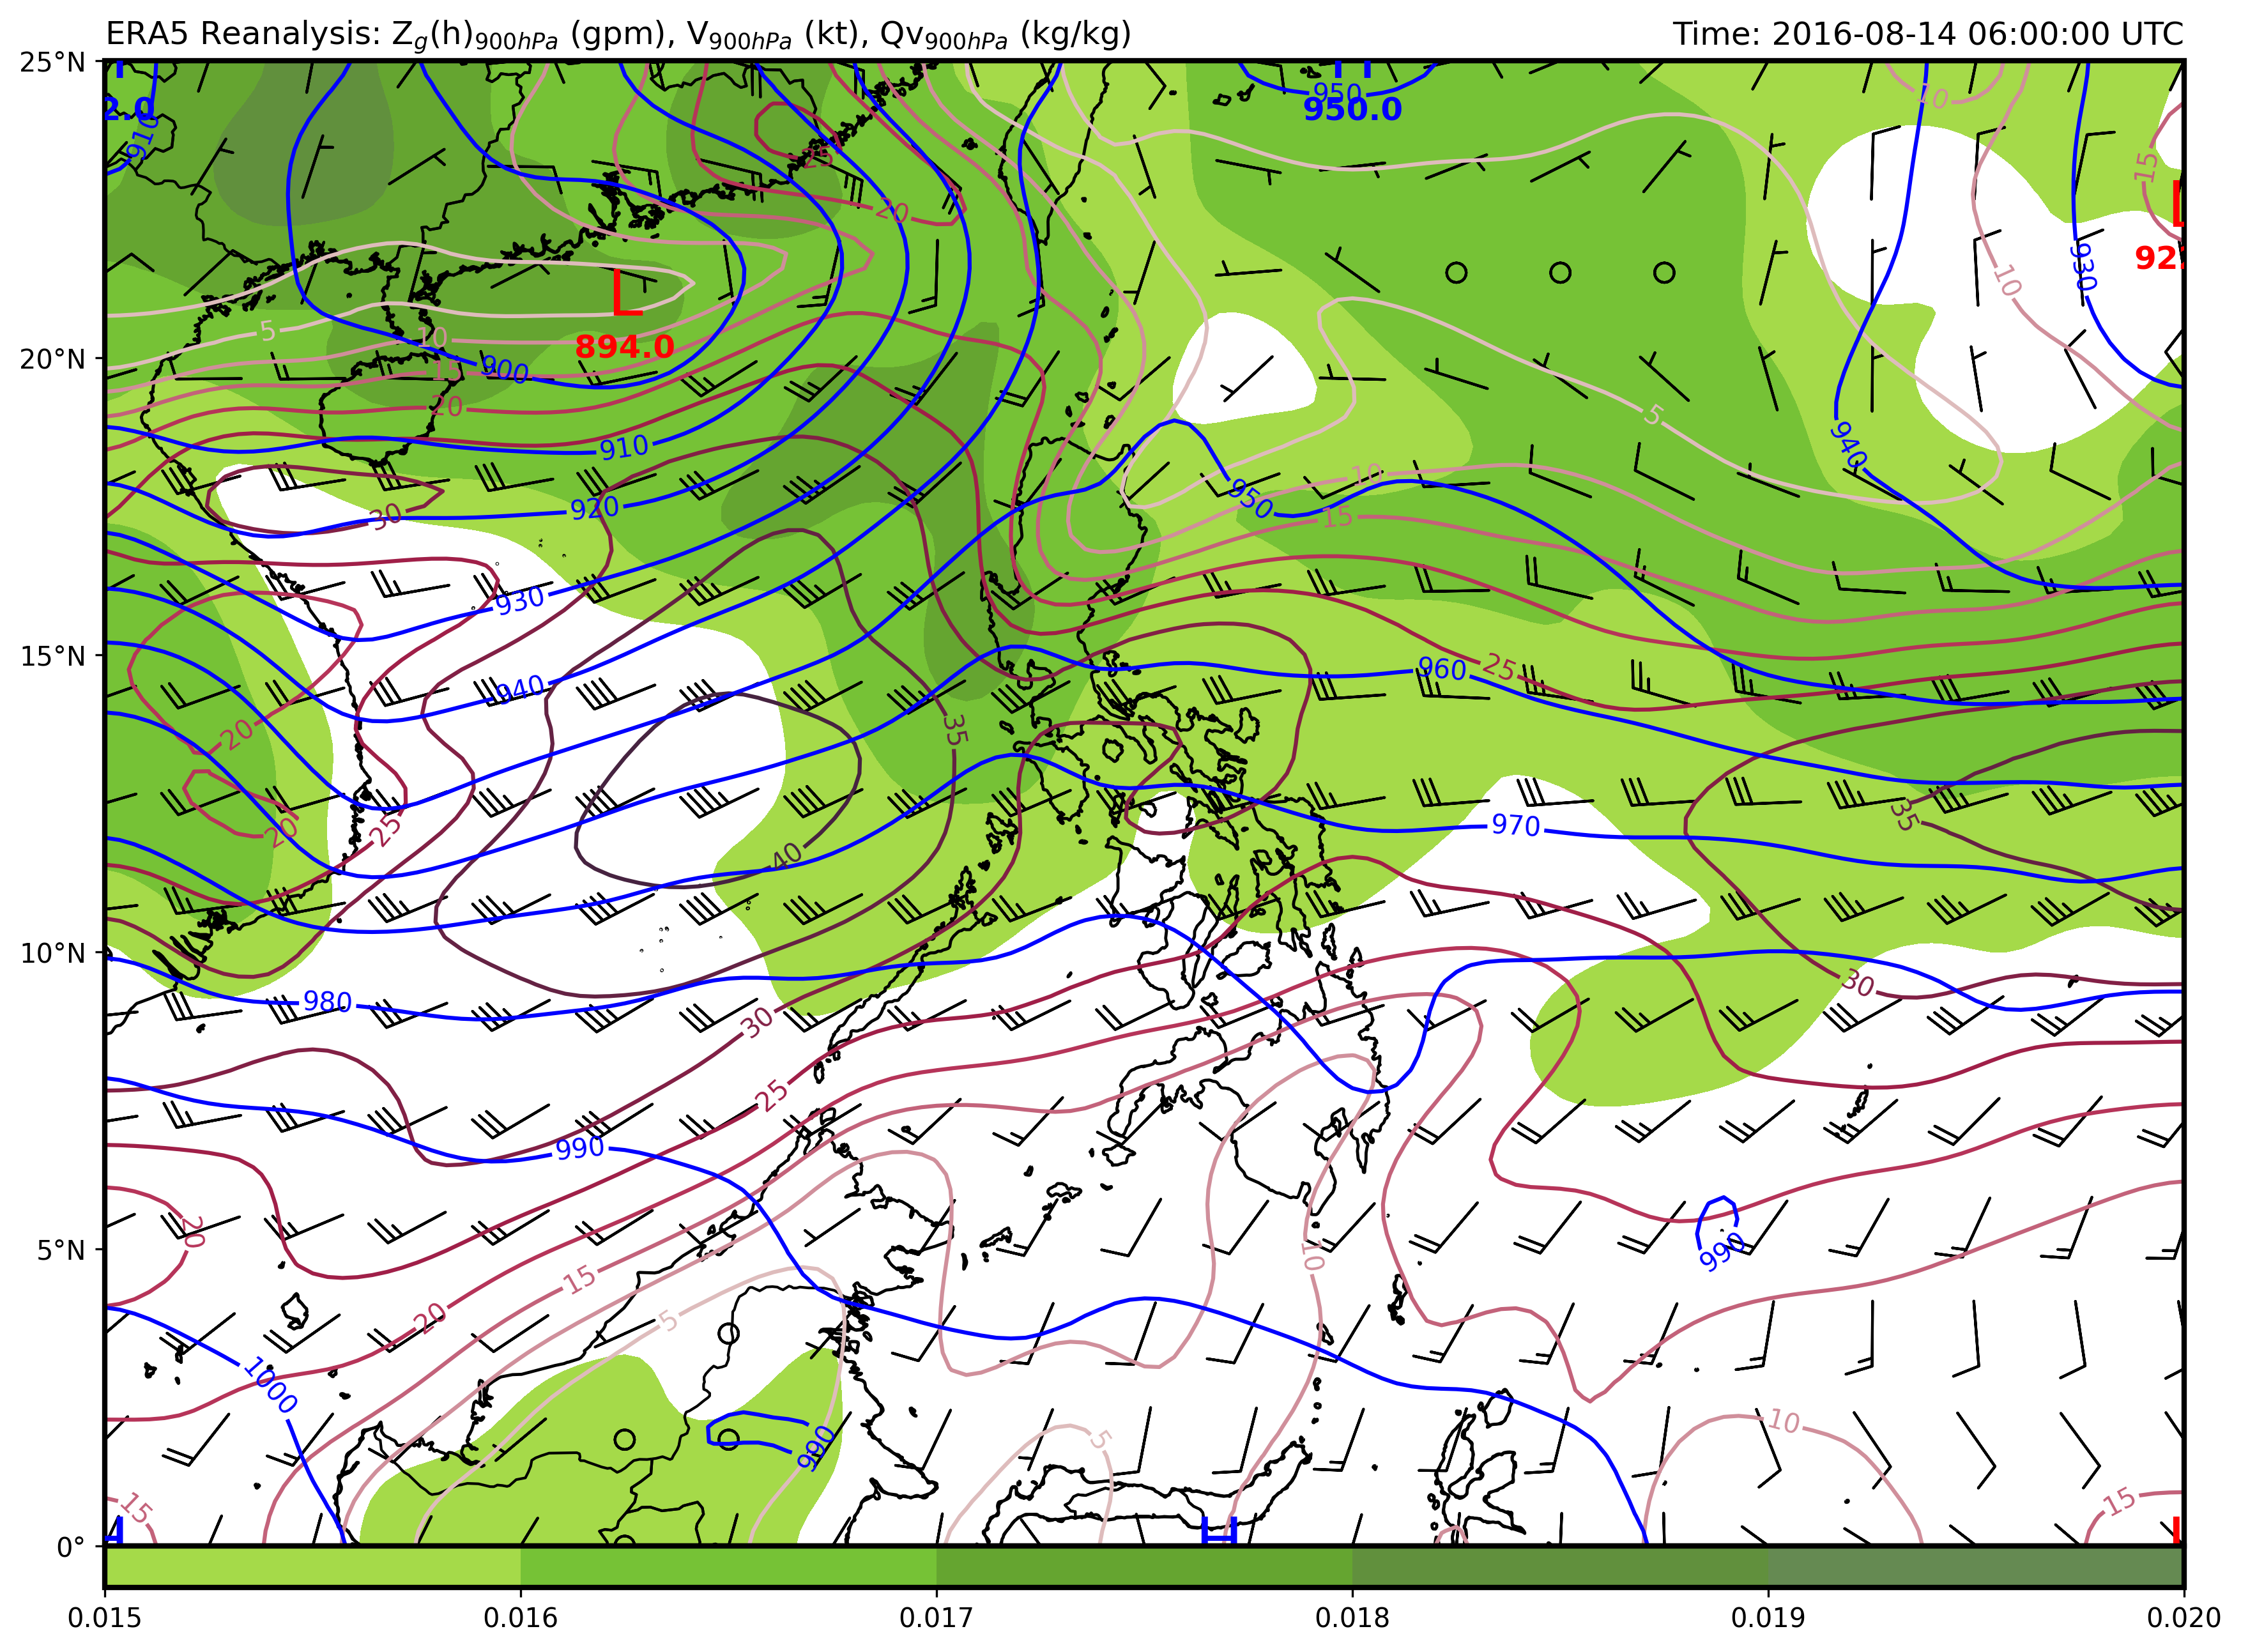

In [76]:
hex_list = ['#c1e754', '#7ac938', '#65a630', '#608c41', '#698a5d']

# Set up the projection that will be used for plotting
mapcrs = ccrs.PlateCarree()

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=datacrs)
ax.set_extent([105, 140, 0, 25], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1.15)
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot 900-hPa Contour Wind Speeds in knots
clevs_900_sped = np.arange(0, 50, 5)
cf = ax.contour(lons, lats, sped_900, clevs_900_sped, cmap="swift.red_r",
                 transform=datacrs)
ax.clabel(cf, fmt='%d')

# Plot 900-hPa Colorfill Specific Humidity
clevs_900_q = np.arange(0.015, 0.02, 0.001)
cf = ax.contourf(lons, lats, q_900, clevs_900_q, cmap=get_continuous_cmap(hex_list),
                 transform=datacrs)
plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)

# Plot 900-hPa Geopotential Heights in meters
clevs_900_hght = np.arange(890, 1010, 10)
cs = ax.contour(lons, lats, hght_900, clevs_900_hght, colors='blue',
                transform=datacrs)
ax.clabel(cs, fmt='%d')

# Plot 900-hPa wind barbs in knots, regrid to reduce number of barbs
ax.barbs(lons, lats, uwnd_900.to('kt').m, vwnd_900.to('kt').m, pivot='middle',
         color='black', regrid_shape=15, transform=datacrs)

plot_maxmin_points(lons, lats, hght_900, 'max', 40, symbol='H', color='b', transform=datacrs)
plot_maxmin_points(lons, lats, hght_900, 'min', 20, symbol='L', color='r', transform=datacrs)

# Make some nice titles for the plot (one right, one left)
plt.title('ERA5 Reanalysis: Z$_{g}$(h)$_{900hPa}$ (gpm), V$_{900hPa}$ (kt), Qv$_{900hPa}$ (kg/kg)', loc='left')
plt.title('Time: {} UTC'.format(vtime), loc='right')

# Set Y-ticks for Latitude Coordinates
ax.set_yticks(lats, 5, crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.minorticks_off()

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'
plt.savefig('GPM, Winds, Qv.jpg', bbox_inches="tight")
plt.show()